# autoMI on Drosophila behavioral states
This notebooks looks at Drosophila behaviors. Behaviors are quantified as MotionMapper states from Berman et al (linked below). 

The MI decay isn't perfectly well fit by any of the models we have seen in the previous notebooks (powerlaw, exponential, or combined). We demonstate a best-fit model comparison with these models. 

See
- [Predictability and hierarchy in Drosophila behavior. G Berman, W Bialek, JW Shaevitz, (2016) PNAS](https://www.pnas.org/content/113/42/11943.full)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib import mlab
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from scipy.io import loadmat

### Load dataset

In [3]:
mat_file = '../assets/berman_drosophila-transition_data.mat'

In [4]:
ds = loadmat(mat_file)

In [5]:
states = [np.concatenate(np.concatenate(i)) for i in ds['transition_states']]\

In [6]:
len(states)

59

In [7]:
len(np.unique(np.concatenate(states)))

117

In [8]:
len(states[0])

10803

### compute autoMI decay

In [9]:
from automi import sequential_mutual_information as smi

In [10]:
range_ = np.arange(1,1001)

In [11]:
(MI, _), (shuff_MI, _) = smi(
    states, distances=range_
)

  0%|          | 0/1000 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   22.7s finished


  0%|          | 0/1000 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   26.1s finished


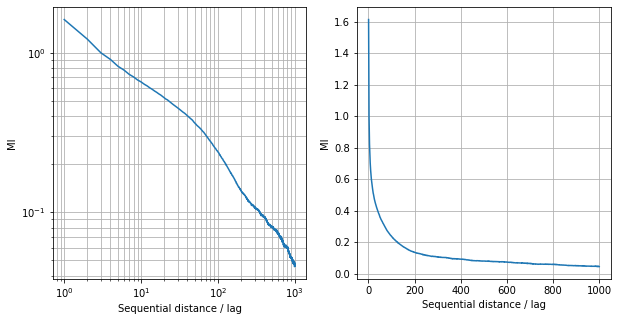

In [12]:
fig, axs = plt.subplots(ncols=2, figsize=(10,5))
ax = axs[0]
ax.plot(range_, MI - shuff_MI)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('MI')
ax.set_xlabel('Sequential distance / lag')
ax.set_ylabel('MI')
ax.grid(which='both')

ax = axs[1]
ax.plot(range_, MI - shuff_MI)
ax.set_xlabel('MI')
ax.set_xlabel('Sequential distance / lag')
ax.set_ylabel('MI')
ax.grid(which='both')


## Fit models

### Fitting a powerlaw decay model

In [13]:
from automi import fit_model

In [14]:
powerlaw_decay_model, y_powerlaw = fit_model(
    distances = range_,
    sig = MI - shuff_MI,
    decay_function = "powerlaw",

)
powerlaw_decay_model

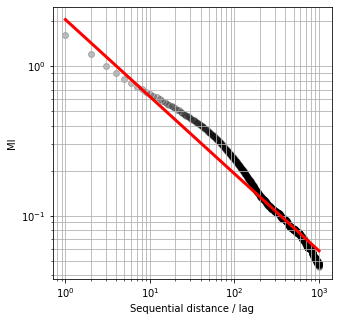

In [15]:
fig, ax = plt.subplots(ncols=1, figsize=(5,5))
ax.scatter(range_, MI - shuff_MI, color = 'k', alpha = 0.25)

ax.plot(range_, y_powerlaw, lw=3, color = 'red')

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Sequential distance / lag')
ax.set_ylabel('MI')
ax.grid(which='both')

### Fitting an exponential decay model

In [16]:
exponential_decay_model, y_exponential = fit_model(
    distances = range_,
    sig = MI - shuff_MI,
    decay_function = "exponential",

)
exponential_decay_model

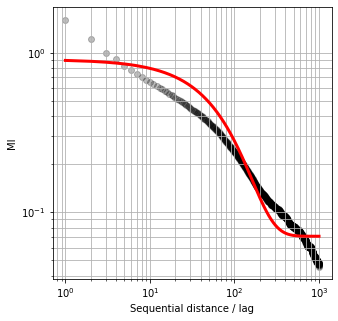

In [17]:
fig, ax = plt.subplots(ncols=1, figsize=(5,5))
ax.scatter(range_, MI - shuff_MI, color = 'k', alpha = 0.25)

ax.plot(range_, y_exponential, lw=3, color = 'red')

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Sequential distance / lag')
ax.set_ylabel('MI')
ax.grid(which='both')

### Fitting a powerlaw-exponential model

In [18]:
pow_exp_decay_model, y_pow_exp = fit_model(
    distances = range_,
    sig = MI - shuff_MI,
    decay_function = "pow_exp",

)
pow_exp_decay_model

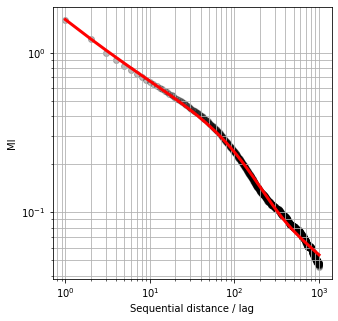

In [19]:
fig, ax = plt.subplots(ncols=1, figsize=(5,5))
ax.scatter(range_, MI - shuff_MI, color = 'k', alpha = 0.25)

ax.plot(range_, y_pow_exp, lw=3, color = 'red')

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Sequential distance / lag')
ax.set_ylabel('MI')
ax.grid(which='both')

## Model comparison on the basis of AICc
For each model, get r2 and AICc. Use those to compute the $\Delta$AICc. From $\Delta$AICc, compute the relative likelihood. From relative likelihood, compute relative probability. 

For more info on comparisons see [AIC model selection and multimodel inference in behavioral ecology: some background, observations, and comparison. Burnham et al., (2011) Behavioral Ecology and Sociobiology](http://dx.doi.org/10.1007/s00265-010-1084-z)

In [20]:
from automi.modelfitting.comparison import r2, AICc, compute_relative_likelihoods, compute_relative_probabilities

In [21]:
sig = MI - shuff_MI
distances = range_

In [22]:
R2_exp = r2(sig, y_exponential, distances, logscaled=True)
R2_pow_exp = r2(sig, y_pow_exp, distances, logscaled=True)
R2_power = r2(sig, y_powerlaw, distances, logscaled=True)

In [23]:
AICc_exp = AICc(
    len(distances),
    len(exponential_decay_model.params),
    sig,
    y_exponential,
    distances,
    logscaled=True,
)
AICc_pow = AICc(
    len(distances),
    len(powerlaw_decay_model.params),
    sig,
    y_powerlaw,
    distances,
    logscaled=True,
)
AICc_pow_exp = AICc(
    len(distances),
    len(pow_exp_decay_model.params),
    sig,
    y_pow_exp,
    distances,
    logscaled=True,
)
AICcs = [AICc_pow_exp, AICc_pow, AICc_exp]
AICcs

[-9311.756542465715, -7187.298519758642, -6100.409294345561]

In [24]:
delta_AICc_pow_exp = AICc_pow_exp - np.min(AICcs)
delta_AICc_pow = AICc_pow - np.min(AICcs)
delta_AICc_exp = AICc_exp - np.min(AICcs)

In [25]:
delta_AICcs = np.array([delta_AICc_pow_exp, delta_AICc_pow, delta_AICc_exp]).astype(
    np.float64
)
delta_AICcs

array([   0.        , 2124.45802271, 3211.34724812])

In [26]:
relative_likelihoods = compute_relative_likelihoods(delta_AICcs)
relative_likelihoods

array([1., 0., 0.])

In [27]:
relative_probabilities = compute_relative_probabilities(relative_likelihoods)
relative_probabilities

array([1., 0., 0.])

### Model comparison on the basis of Likelihood Ratio Test

In [28]:
from automi.modelfitting.comparison import LRT

In [29]:
LL1, LL2, p = LRT(
    true_y = sig,
    model1_y = y_powerlaw,
    model2_y = y_pow_exp,
    model1_nparams  = len(powerlaw_decay_model.params),
    model2_nparams = len(pow_exp_decay_model.params),
    distances = distances, 
    logscaled=True
)

In [30]:
LL1, LL2, p

(3596.661308072092, 4660.908452319377, 0.0)